# Airline On-Time Performance Data
## by João Victor Moreira de Figueiredo

## Investigation Overview

1. On which days of the week are flights most common?
2. Which carrier does the most flights and what is the total percentage compared to its competitors?
3. Why was there a big increase in the "Security" cancellation reason from February to April 2020?

## Dataset Overview

Reporting carriers are required to (or voluntarily) report on-time data for flights they operate: on-time arrival and departure data for non-stop domestic flights by month and year, by carrier and by origin and destination airport. Includes scheduled and actual departure and arrival times, canceled and diverted flights, causes of delay and cancellation, air time, and non-stop distance.

This project explore twelve months of data, starting at May 2019 to April 2020 totaling approximately 7 million flights. The first two plots in this presentation do not consider cancelled flights.

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [2]:
# load in the dataset into a pandas dataframe
import zipfile
import os
import time
import glob
import requests

if os.path.exists('files/data/260700039_T_ONTIME_REPORTING11.csv'):
    pass
else:
    dir_files = os.listdir('files/data/')
    count_files = 0
    listfiles = []
    
    for i in dir_files:
        with zipfile.ZipFile('files/data/'+i, mode='r') as myzip:
            listfiles.append(zipfile.ZipFile.namelist(myzip)[0])
            myzip.extractall(path='files/data/')
            current_name = listfiles[count_files]
            new_name = listfiles[count_files].split('.')[0]+str(count_files)+'.csv'
        
            if os.path.exists('files/data/'+current_name):
                os.renames('files/data/'+current_name, 'files/'+new_name)
        
            count_files+=1
            
file_names = glob.glob('files/data/*.csv')
df = pd.concat((pd.read_csv(x) for x in file_names), ignore_index=True)

week_days = 'https://www.transtats.bts.gov/Download_Lookup.asp?Lookup=L_WEEKDAYS'
week_days_file = week_days.split('=')[-1]+'.csv'   

carriers = 'https://www.transtats.bts.gov/Download_Lookup.asp?Lookup=L_UNIQUE_CARRIERS'
carr_file = carriers.split('=')[-1]+'.csv'

cancellation_desc = 'https://www.transtats.bts.gov/Download_Lookup.asp?Lookup=L_CANCELLATION'
canc_file = cancellation_desc.split('=')[-1]+'.csv'


if os.path.exists('files/supplementary_data'):
    pass
else:
    os.mkdir('files/supplementary_data')

if requests.get('https://www.transtats.bts.gov/').status_code == 200:
    with open('files/supplementary_data/'+week_days_file, mode='wb') as file:
        file.write(requests.get(week_days).content)

    with open('files/supplementary_data/'+carr_file, mode='wb') as file:
        file.write(requests.get(carriers).content)
    
    with open('files/supplementary_data/'+canc_file, mode='wb') as file:
        file.write(requests.get(cancellation_desc).content)
else:
    pass

# Load supplementary data into dataframe
week_days = pd.read_csv('files/supplementary_data/'+week_days_file)
carriers = pd.read_csv('files/supplementary_data/'+carr_file)
cancellation_desc = pd.read_csv('files/supplementary_data/'+canc_file)

df = df.merge(week_days['Description'], left_on='DAY_OF_WEEK',right_on=week_days['Code'], how='left')
df.rename(columns={'Description':'WEEK_DAY_NAME'}, inplace=True)

df = df.merge(carriers['Description'], left_on='OP_UNIQUE_CARRIER',right_on=carriers['Code'], how='left')
df.rename(columns={'Description':'CARRIER_NAME'}, inplace=True)

df = df.merge(cancellation_desc['Description'], left_on='CANCELLATION_CODE',right_on=cancellation_desc['Code'], how='left')
df.rename(columns={'Description':'CANCELLATION_REASON'}, inplace=True)

df_clean = df.copy()

df_clean.drop(columns='Unnamed: 29', axis=1, inplace=True)
df_clean.drop(index=df_clean[df_clean['DEST'] == '1344'].index, axis=0, inplace=True)
df_clean.reset_index(drop=True, inplace=True)

df_clean.drop(columns=['OP_UNIQUE_CARRIER','ORIGIN','DEST','CANCELLATION_CODE'], axis=1, inplace=True)

columns = ['YEAR','MONTH','DAY_OF_MONTH','DAY_OF_WEEK','WEEK_DAY_NAME','OP_CARRIER_FL_NUM',
           'CARRIER_NAME','DISTANCE','CANCELLED','CANCELLATION_REASON']

df_cancelled = df_clean[columns].query("CANCELLED == 1")
df_cancelled.reset_index(drop=True,inplace=True)

df_clean = df_clean.drop(df_clean.query("CANCELLED == 1").index, axis=0)
df_clean.reset_index(drop=True, inplace=True)

concat_func = lambda x,y: str(x) + '-' + str(y)
df_cancelled['MONTH_YEAR'] = df_cancelled.MONTH.combine(df_cancelled.YEAR, func=concat_func)

df_cancelled['MONTH_YEAR'] = pd.to_datetime(df_cancelled['MONTH_YEAR'], format='%m-%Y')

canc_rs_all = df_cancelled.groupby(['MONTH_YEAR','CANCELLATION_REASON'])['CANCELLATION_REASON'].count()

canc_rs_all = canc_rs_all.reset_index(level=['MONTH_YEAR','CANCELLATION_REASON'], name='TOTAL')

canc_rs_sec = canc_rs_all.query("CANCELLATION_REASON == 'Security'")
canc_rs = canc_rs_all.drop(canc_rs_all.query("CANCELLATION_REASON == 'Security'").index, axis=0)
canc_rs.reset_index(drop=True, inplace=True)

In [3]:
def millions(x, pos):
    # The two args are the value and tick position'
    return '%1.1fM' % (x * 1e-6)

## Distribution of flights in days of week

Most flights are in friday while on saturday it has less demands but generally, we have balance in the distribution of flights during the week.

(Press the down arrow on your keyboard to view the plot)

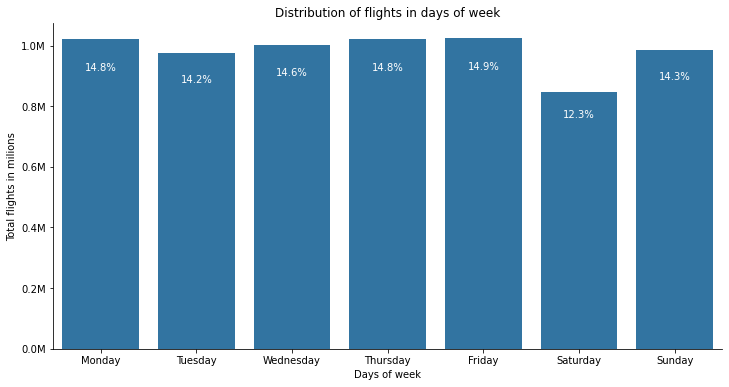

In [11]:
global_color = sb.color_palette()[0]
total_flights = df_clean.shape[0]

week_count = df_clean['DAY_OF_WEEK'].value_counts(sort=False)

fig, ax = plt.subplots(figsize=(12,6))
sb.countplot(data=df_clean, x='DAY_OF_WEEK', color=global_color)

for i in range(week_count.shape[0]):
    count = week_count[i+1]
    pct_string = '{:0.1f}%'.format(100 * count / total_flights)
    plt.text(x=i, y=count - (count*10/100), s=pct_string, ha='center', color='w')

    
# Use function to format the y axis
formatter = FuncFormatter(millions)
ax.yaxis.set_major_formatter(formatter)

right_side = ax.spines["right"]
right_side.set_visible(False)
top_side = ax.spines["top"]
top_side.set_visible(False)

plt.xticks(np.arange(0, len(week_days.Description[0:7]),1), labels=week_days.Description[0:7].values)
plt.title("Distribution of flights in days of week")
plt.xlabel("Days of week")
plt.ylabel("Total flights in milions");

## Total flights in May 2019 to April 2020 by carriers

It is impressive to note that the airline that has the most flights in the period represents only 18% of the total, a fact that demonstrates fierce competition between carriers.

(Press the down arrow on your keyboard to view the plot)

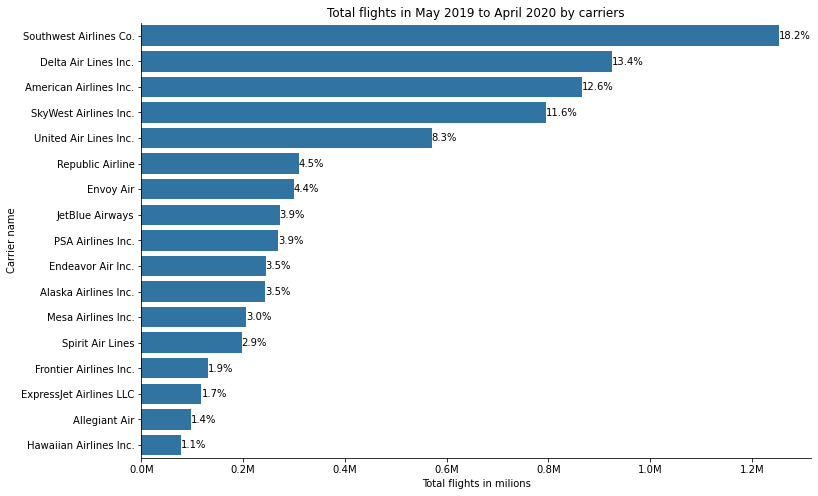

In [12]:
carrier_counts = df_clean['CARRIER_NAME'].value_counts()
order = carrier_counts.index

fig, ax = plt.subplots(figsize=(12,8))
sb.countplot(data=df_clean, y='CARRIER_NAME', order=order, color=global_color);

for i in range(carrier_counts.shape[0]):
    count = carrier_counts[i]
    pct_string = '{:0.1f}%'.format(100 * count / total_flights)
    plt.text(x=count+1, y=i, s=pct_string, va='center')

# Use function to format the x axis
formatter = FuncFormatter(millions)
ax.xaxis.set_major_formatter(formatter)

right_side = ax.spines["right"]
right_side.set_visible(False)
top_side = ax.spines["top"]
top_side.set_visible(False)

plt.title("Total flights in May 2019 to April 2020 by carriers")
plt.ylabel("Carrier name")
plt.xlabel("Total flights in milions");

## Cancellation reasons

Looking the data, observe that "Security" reason have a very large difference in relation with other reasons. This issue is explained in the next slide.

(Press the down arrow on your keyboard to view the plot)

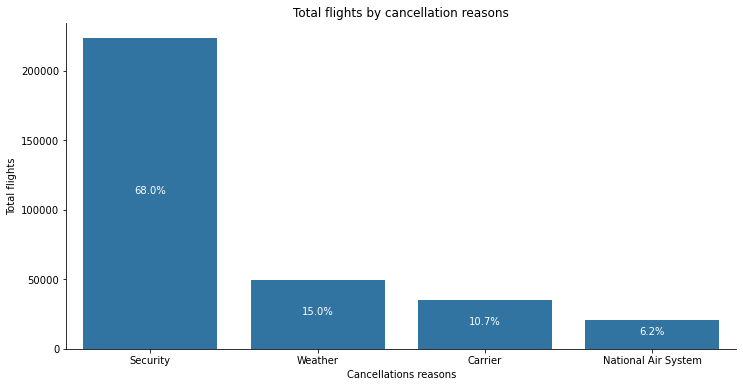

In [13]:
fig, ax = plt.subplots(figsize=(12,6))
total_reasons = df_cancelled['CANCELLATION_REASON'].value_counts()
cancelled_flights = df_cancelled.shape[0]

for i in range(total_reasons.shape[0]):
    count = total_reasons[i]
    pct_string = '{:0.1f}%'.format(100 * count / cancelled_flights)
    plt.text(x=i, y=count - (count*50/100), s=pct_string, ha='center', color='w')

order = df_cancelled['CANCELLATION_REASON'].value_counts().index
sb.countplot(data=df_cancelled, x='CANCELLATION_REASON', order=order, color=global_color)

right_side = ax.spines["right"]
right_side.set_visible(False)
top_side = ax.spines["top"]
top_side.set_visible(False)

plt.title("Total flights by cancellation reasons")
plt.xlabel("Cancellations reasons")
plt.ylabel("Total flights");

## Total cancelled flights by cancellation reasons along the months

Interestingly looking at these plot and that there was a spike in cancellation for "Security" and "Carrier" reasons starting at almost the same time (Feb 2020), two days after a declaration of outbreak of COVID-19 to be a Public Health Emergency of International Concern (On 30 January 2020). <a href='https://www.who.int/news-room/detail/27-02-2020-a-joint-statement-on-tourism-and-covid-19---unwto-and-who-call-for-responsibility-and-coordination#:~:text=On%2030%20January%202020%2C,set%20of%20Temporary%20Recommendations' target="_blank">WHO statement</a>

Many flights canceled by the "Carrier" themselves, but the overwhelming majority for "Security" reasons, which were rarely used in the months before Feb 2020.

(Press the down arrow on your keyboard to view the plot)

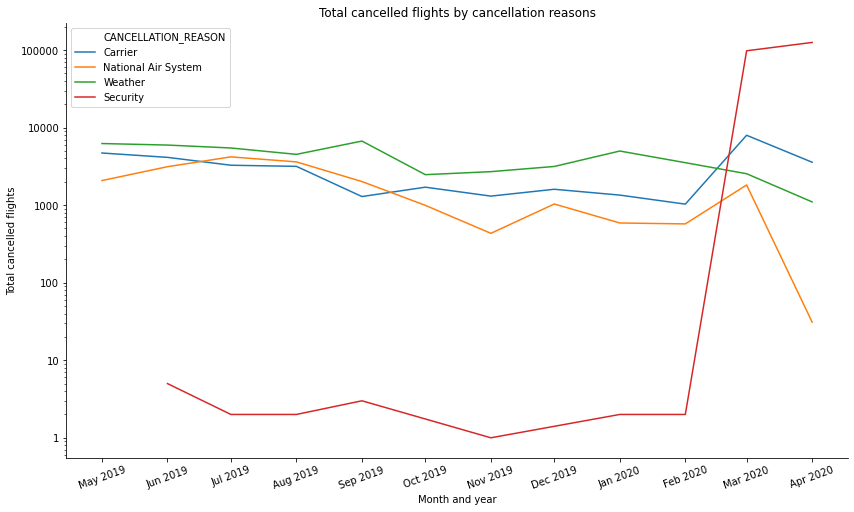

In [15]:
fig, ax = plt.subplots(figsize=(14,8))

ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(canc_rs_all.MONTH_YEAR.value_counts().index, rotation=20)

plt.yscale('log')
sb.lineplot(data=canc_rs_all, x='MONTH_YEAR', y='TOTAL', hue='CANCELLATION_REASON', ax=ax)

ticks = [1, 10, 100, 1000, 10000, 100000]
labels = ['{}'.format(v) for v in ticks]
plt.yticks(ticks, labels)

right_side = ax.spines["right"]
right_side.set_visible(False)
top_side = ax.spines["top"]
top_side.set_visible(False)

plt.title("Total cancelled flights by cancellation reasons")
plt.ylabel("Total cancelled flights")
plt.xlabel("Month and year")

plt.show();

## End of presentattion